In [39]:
#  Solar Module
import time

resource_type:str="solar" #use all small letters
# Start the script run timer
script_start_time = time.time()

In [40]:
import logging as log

import atlite
import os
from scipy.spatial import cKDTree
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm import tqdm
from atlite.gis import shape_availability, ExclusionContainer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point
import xarray as xr
import argparse

### Local Packages

In [41]:
from linkingtool import linking_utility as utils
from linkingtool import linking_vis as vis
from linkingtool import linking_solar as solar

In [42]:
# for notebook run
config_file_path='config/config_linking_tool.yml'

In [43]:
# def main(config_file_path:str):

log_path=f'workflow/log/{resource_type}_module_log.txt'
log=utils.create_log(log_path)
utils.print_module_title(f'{resource_type} module initiated')
log.info(f"Loading Configuration Data and Directories...")


2024-09-18 11:16:22 - INFO - Loading Configuration Data and Directories...


____________________________________________________________
     solar module initiated
____________________________________________________________


In [44]:
# User Configuration
config:dict[dict]=utils.load_config(config_file_path)

current_region:dict = config['regional_info']['region_1']
_CRC_=current_region['code'] # Current Region Code i.e. BC

disaggregation_config:dict=config['capacity_disaggregation']

linking_data:dict=config['processed_data']['linking']
vis_dir:str=os.path.join(config['visualization']['linking'],resource_type)

resource_landuse_intensity = disaggregation_config[f'{resource_type}']['landuse_intensity'] # (MW/km2) from literature 1.7 MW/km2

linking_data:dict=config['processed_data']['linking']

ATB_NREL_cost_datafile=disaggregation_config[f'{resource_type}']['cost_data']
utility_PV_cost=pd.read_csv(ATB_NREL_cost_datafile)
# Set COST parameters (global for PV)
solar_fom=utility_PV_cost[utility_PV_cost['core_metric_parameter']=='Fixed O&M'].value.iloc[0]/1E3  # mill. $/MW = ($/kw ) /1E3
print(f"Solar PV FOM set to: {round(solar_fom,2)} Mil. USD/ MW. Sourced from >> Summary data, Utility PV Cost, ATB 2024 , NREL ")

solar_capex=utility_PV_cost[utility_PV_cost['core_metric_parameter']=='CAPEX'].value.iloc[0]/1E3 # mill. $/MW = ($/kw ) /1E3
print(f"Solar PV CAPEX set to: {round(solar_capex,2)} Mil. USD/ MW. Sourced from >> Summary data, Utility PV Cost, ATB 2024 , NREL ")

solar_vom=0

# capex = disaggregation_config[f'{resource_type}']['capex'] # Mil. USD/MW  *** Later to be linked to NREL ATB Spreadsheet (via data pipeline automation) for different TECH class, different years.
grid_connection_cost_per_Km = disaggregation_config['transmission']['grid_connection_cost_per_Km'] #M$/km   # from MISO , may try NREL method for different range of distance
tx_line_rebuild_cost = disaggregation_config['transmission']['tx_line_rebuild_cost']  #M$/km # from MISO

grid_node_proximity_filter = disaggregation_config['transmission']['proximity_filter']
wcss_tolerance=disaggregation_config[f'{resource_type}']['WCSS_tolerance']

gadm_file=os.path.join(config['GADM']['root'],config['GADM']['datafile'])

# Raster Configurations
GAEZ_data:dict= config['GAEZ']
rasters_in_use_direct =GAEZ_data['Rasters_in_use_direct']

land_cover_config = GAEZ_data['land_cover']
terrain_resources_config = GAEZ_data['terrain_resources']
# exclusion_areas_config =GAEZ_data['exclusion_areas']

# Raster Files
gaez_landcover_raster = os.path.join(GAEZ_data['root'], rasters_in_use_direct, land_cover_config['zip_extract_direct'], land_cover_config['raster'])
gaez_terrain_raster = os.path.join(GAEZ_data['root'], rasters_in_use_direct, terrain_resources_config['zip_extract_direct'], terrain_resources_config['raster'])
# gaez_exclusionAreas_raster = os.path.join(parent_direct, rasters_in_use_direct, exclusion_areas_config['zip_extract_direct'], exclusion_areas_config['raster'])

# Raster class and buffer information 
land_class_inclusion = land_cover_config['class_inclusion'][f'{resource_type}']  #inclusion layer
terrain_class_exclusion= terrain_resources_config['class_exclusion'][f'{resource_type}'] #exclusion layer
# terrain_class_exclusion_buffer=terrain_resources_config['class_exclusion']['buffer'][f'{resource_type}'] #m

aeroway_file_path=os.path.join(linking_data['root'],resource_type,f"aeroway_OSM_{_CRC_}_with_buffer_{resource_type}.parquet")
# exclusionAreas__class_exclusion= exclusion_areas_config['class_exclusion'][f'{resource_type}']  #exclusion layer
# exclusionAreas__class_exclusion_buffer=exclusion_areas_config['class_exclusion']['buffer'][f'{resource_type}'] #m

Solar PV FOM set to: 0.02 Mil. USD/ MW. Sourced from >> Summary data, Utility PV Cost, ATB 2024 , NREL 
Solar PV CAPEX set to: 1.48 Mil. USD/ MW. Sourced from >> Summary data, Utility PV Cost, ATB 2024 , NREL 


In [45]:
# Load Data Files ------------------------------
gadm_regions_gdf = gpd.read_file(gadm_file)
aeroway_with_buffer=gpd.read_parquet(aeroway_file_path)
conservation_lands_province_datafile:str= os.path.join(linking_data['root'],linking_data['CPCAD_org'])
# gov_conservation_lands_consideration=config['Gov']['conservation_lands']['consideration'][f'{resource_type}']
conservation_lands_province=gpd.read_parquet(conservation_lands_province_datafile)

log.info(F"Loading Transmission Nodes' data")
buses_gdf = gpd.GeoDataFrame(pd.read_pickle(os.path.join('data/processed_data',linking_data['transmission']['nodes_datafile'])))

2024-09-18 11:16:23 - INFO - Loading Transmission Nodes' data


In [46]:
cutout_config=config['cutout']

In [47]:
cutout_config

{'root': 'data/downloaded_data/cutout',
 'module': ['era5'],
 'year': 2022,
 'start_date': '2022-01-01',
 'end_date': '2022-12-31',
 'dx': 0.25,
 'dy': 0.25,
 'snapshots': {'start': ['2021-01-01 07:00:00'],
  'end': ['2022-01-01 06:00:00']},
 'snapshots_tz_BC': {'start': ['2021-01-01 00:00:00'],
  'end': ['2021-12-31 23:00:00']},
 'timezone_convert': 'Etc/GMT+7'}

In [48]:
 cutout_config['snapshots']['start']

['2021-01-01 07:00:00']

In [49]:
current_region

{'code': 'BC',
 'name': 'British Columbia',
 'area': 944735,
 'boundary': {'GADM_directory': 'data/GADM',
  'GADM_file': 'data/GADM/BC/BC_gadm_regions.geojson'},
 'OSM_datafile': 'data/OSM/BC/BC.osm.pbf',
 'OSM_aeroway_datafile': 'data/OSM/aeroway/BC/aeroway_OSM_BC.geojson',
 'cutout_datafile': 'data/downloaded_data/cutout/BC_2021_2022.nc',
 'cutout_bounding_box': {'automated': True,
  'user_defined': {'minx': -139.25,
   'maxx': -112.25,
   'miny': 45.25,
   'maxy': 60.25}},
 'conservation_lands_provincial_id': 2,
 'conservation_lands_datafile': 'data/Gov/Conservation_Lands/BC/CPCAD_BC_union.pkl',
 'region_mapping': {'Northern Rockies': 1,
  'Stikine': 2,
  'Peace River': 3,
  'Kitimat-Stikine': 4,
  'Bulkley-Nechako': 5,
  'Fraser-Fort George': 6,
  'Skeena-Queen Charlotte': 7,
  'Cariboo': 8,
  'Central Coast': 9,
  'Columbia-Shuswap': 10,
  'Mount Waddington': 11,
  'Thompson-Nicola': 12,
  'Squamish-Lillooet': 13,
  'North Okanagan': 14,
  'Powell River': 15,
  'East Kootenay': 16

In [50]:
start_date[0]

'2'

In [51]:
## load ERA5 Cutout 
log.info(f"Loading ERA5 Cutout...")
# start_date = str(cutout_year)+"-01-01"
start_date = cutout_config['snapshots']['start'][0] #sync with pypsa config
# end_date = str(cutout_year)+"-12-31"
end_date = cutout_config['snapshots']['end'][0] #sync with pypsa config
cutout_datafile=current_region['cutout_datafile']
# cutout=atlite.Cutout(os.path.join(config['cutout']['directory'],f"{_CRC_}_{cutout_year}.nc"))
cutout=atlite.Cutout(cutout_datafile)

2024-09-18 11:16:23 - INFO - Loading ERA5 Cutout...


In [52]:
# 1 Extract BC Grid Cells from Cutout using Regional Boundaries from GADM

province_grid_cells = cutout.grid.overlay(gadm_regions_gdf, how='intersection',keep_geom_type=True)
log.info(f"Extracted {len(province_grid_cells)} ERA5 Grid Cells for {current_region['code']} from Cutout")

2024-09-18 11:16:23 - INFO - Extracted 2956 ERA5 Grid Cells for BC from Cutout


2024-09-18 11:16:23 - INFO - Calculating land availability by -  Excluding terrain  with >30% slope...


The eligibility share is: 99.16%


Compute availability matrix: 100%|██████████| 1/1 [00:03<00:00,  3.62s/ gridcells]
2024-09-18 11:16:31 - INFO - Calculated Land Availability data loaded for  2186 Cells in Col.:2_land_avail_low_slop.

2024-09-18 11:16:31 - INFO - Calculating land availability by -  Eligible Land Classes...



Region of Interest : BC
 > Eligible Land Area of the  Grid Cells = 832,053 Km²
 > Actual Land Area : 944,735 km²

The eligibility share is: 52.08%


Compute availability matrix: 100%|██████████| 1/1 [00:03<00:00,  3.87s/ gridcells]
2024-09-18 11:16:39 - INFO - Calculated Land Availability data loaded for  1882 Cells in Col.:3_land_avail_eligible.

2024-09-18 11:16:39 - INFO - Calculating land availability by - Excluding Conservation and Protected lands by Canadian Gov....



Region of Interest : BC
 > Eligible Land Area of the  Grid Cells = 409,850 Km²
 > Actual Land Area : 944,735 km²

The eligibility share is: 100.00%


Compute availability matrix: 100%|██████████| 1/1 [00:03<00:00,  3.75s/ gridcells]
2024-09-18 11:16:47 - INFO - Calculating land availability by - Excluding Aeroway with buffer...



Region of Interest : BC
 > Eligible Land Area of the  Grid Cells = 393,991 Km²
 > Actual Land Area : 944,735 km²

The eligibility share is: 100.00%


Compute availability matrix: 100%|██████████| 1/1 [00:00<00:00,  1.08 gridcells/s]



Region of Interest : BC
 > Eligible Land Area of the  Grid Cells = 382,876 Km²
 > Actual Land Area : 944,735 km²



2024-09-18 11:16:50 - INFO - Plot Created for Land Availability (solar) for Potential Plants and Save to vis/linking/solar/Land Availability for Potential solar Plants.png
2024-09-18 11:16:50 - INFO - Calculating Potential Capacity for BC Grid Cells based on eligible land area
2024-09-18 11:16:50 - INFO - Potential Capacity for Provincial Grid Cells based on available Land calculated



Assuming a literature-based installable tech capacity per unit area: 1.45 MW/km²
Total Resource Potential (based on available land): 555.17 GW 



2024-09-18 11:16:50 - INFO - Plot Created for Potential Capacity (solar) for Potential Plants and Save to vis/linking/solar/Land Availability for Potential solar Plants.png


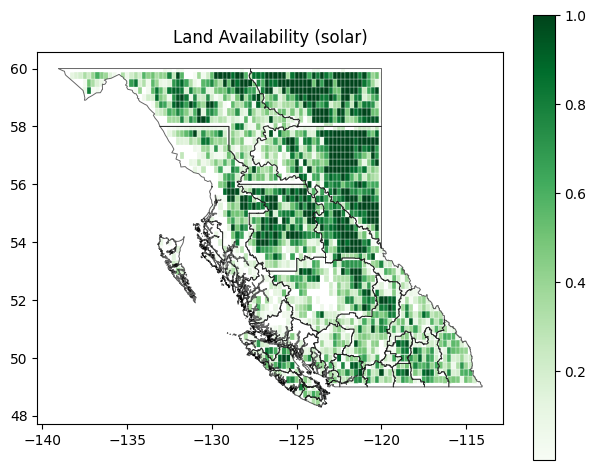

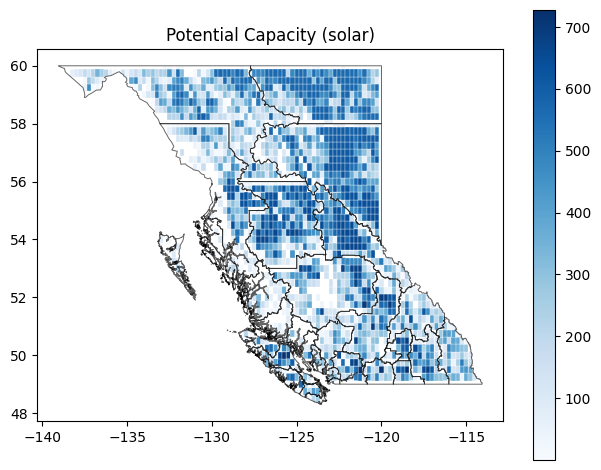

In [53]:
# 2 Calculate Potential Capacity for Cells
## 2.1-2.2
# ERA5_Land_cells_noExclusion=calculate_land_availability_raster(cutout,province_grid_cells,' Excluding exclusion areas',gaez_exclusionAreas_raster,'1_land_avail_exclAreas',exclusionAreas__class_exclusion,actual_area_ROI, buffer=exclusionAreas__class_exclusion_buffer,exclusion=True)
ERA5_Land_cells_low_slop=utils.calculate_land_availability_raster(cutout,province_grid_cells,' Excluding terrain  with >30% slope',gaez_terrain_raster,'2_land_avail_low_slop',terrain_class_exclusion,current_region,buffer=0,exclusion=True)
ERA5_Land_cells_eligible_landclasses=utils.calculate_land_availability_raster(cutout,ERA5_Land_cells_low_slop,' Eligible Land Classes',gaez_landcover_raster,'3_land_avail_eligible',land_class_inclusion,current_region,buffer=0,exclusion=False)

ERA5_Land_cells_nonprotected=utils.calculate_land_availability_vector_data(cutout,ERA5_Land_cells_eligible_landclasses,conservation_lands_province,'Excluding Conservation and Protected lands by Canadian Gov.','4_land_avail_excl_protectedLands',current_region)
ERA5_Land_cells_final=utils.calculate_land_availability_vector_data(cutout,ERA5_Land_cells_nonprotected,aeroway_with_buffer,'Excluding Aeroway with buffer','5_land_avail_excl_aeroway',current_region)
# ERA5_Land_cells_nonaeroway=utils.calculate_land_availability_vector_data(cutout,ERA5_Land_cells_nonprotected,aeroway_with_buffer,'Excluding Aeroway with buffer','5_land_avail_excl_aeroway',current_region)

# ERA5_Land_cells_final=ERA5_Land_cells_eligible_landclasses
ERA5_Land_cells_final['land_availablity']=ERA5_Land_cells_final['eligible_land_area']/ERA5_Land_cells_final['land_area_sq_km']

## vis.plot_data_in_GADM_regions(dataframe,data_column_df,gadm_regions_gdf,color_map,dpi,plt_title,plt_file_name,vis_directory
vis.plot_data_in_GADM_regions(ERA5_Land_cells_final,'land_availablity',
                                gadm_regions_gdf,
                                "Greens",600,f"Land Availability ({resource_type})",
                                f'Land Availability for Potential {resource_type} Plants.png',vis_dir)

## 2.3
province_grid_cells_cap=utils.calculate_potential_capacity(ERA5_Land_cells_final,resource_landuse_intensity,'cell')

vis.plot_data_in_GADM_regions(ERA5_Land_cells_final,'potential_capacity',
                                gadm_regions_gdf,
                                "Blues",600,f"Potential Capacity ({resource_type})",
                                f'Land Availability for Potential {resource_type} Plants.png',vis_dir)

In [54]:
# 3 Find Nearest Grid Nodes and Proximity to these Nodes
province_grid_cells_cap=utils.find_grid_nodes_ERA5_cells(current_region,buses_gdf,province_grid_cells_cap)
province_grid_cells_cap=province_grid_cells_cap.loc[:,['x', 'y', 'COUNTRY', 'Province', 'Region',
    'Region_ID', 'land_area_sq_km','land_availablity', 'eligible_land_area', 'potential_capacity', 'nearest_station',
    'nearest_station_distance_km','geometry']]

2024-09-18 11:16:51 - INFO - > Calculating Nearest Grid Nodes for Grid Cells of BC


In [55]:
# 4 Create CF timeseries
panel_config = disaggregation_config['solar']['atlite_panel']
tracking_config = disaggregation_config['solar']['tracking']

log.info(f">> Calculating Generation in Grid Cells as per the Layout Capacity (MW)...")
province_grid_CF_cells,province_grid_CF_ts_df= solar.create_CF_timeseries_df(cutout,start_date,end_date,province_grid_cells_cap,panel_config,tracking_config,Site_index='cell')

zero_CF_mask=province_grid_CF_cells.CF_mean>0
province_grid_CF_cells = province_grid_CF_cells[zero_CF_mask]

2024-09-18 11:16:51 - INFO - >> Calculating Generation in Grid Cells as per the Layout Capacity (MW)...
2024-09-18 11:16:51 - INFO - Creating Layout for PV generation from BC Grid Cells...
2024-09-18 11:16:51 - INFO - Convert and aggregate 'pv'.


[########################################] | 100% Completed | 122.67 s


/local-scratch/localhome/mei3/eliasinul/repositories/Bidirectional_Linking_Tool/src/linkingtool/linking_solar.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  datetime_index = pd.date_range(start=start_date , end=end_date, freq='H')


>> Calculating CF mean from the 8760 data points for each Cell ...


2024-09-18 11:18:56 - INFO - Plot Created for CF_mean (solar) for Potential Plants and Save to vis/linking/solar/CF_mean of Potential solar Plants.png


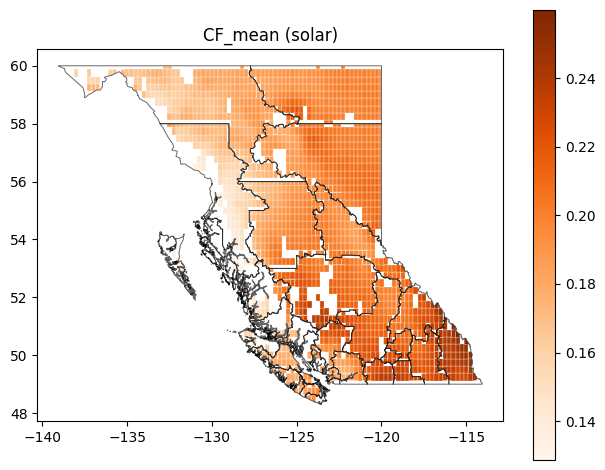

In [56]:
province_grid_CF_ts_df.to_pickle(os.path.join(linking_data['root'],resource_type,linking_data[f'{resource_type}']['ERA5_CF_ts']))
vis.plot_data_in_GADM_regions(province_grid_CF_cells,'CF_mean',
                            gadm_regions_gdf,
                            'Oranges',600,f'CF_mean ({resource_type})',
                            f'CF_mean of Potential {resource_type} Plants.png',vis_dir)

In [57]:

province_grid_CF_cells['capex']=solar_capex

# 5 Calculate Scores for Cells
province_grid_cells_scored=utils.calculate_cell_score(province_grid_CF_cells,grid_connection_cost_per_Km,tx_line_rebuild_cost,'CF_mean',solar_capex)
scored_cells_save_to=os.path.join(linking_data['root'],resource_type,linking_data[f'{resource_type}']['scored_cells'])


province_grid_cells_scored.to_pickle(scored_cells_save_to)

>> Calculating Score for each Cell ...


/localhome/mei3/miniconda3/envs/Linking/lib/python3.12/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [58]:
# 6 Find optimal number of Clusters from K-means clustering 
## > k-means clustering based on the Scores of cells in each region.
## 6.1-6.3
ERA5_cells_cluster_map,region_solar_optimal_k_df = utils.cells_to_cluster_mapping(province_grid_cells_scored,vis_dir,wcss_tolerance)

>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone East Kootenay - Optimal k for p_lcoe based clustering: 2

>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Okanagan-Similkameen - Optimal k for p_lcoe based clustering: 2

>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Central Kootenay - Optimal k for p_lcoe based clustering: 2

>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Columbia-Shuswap - Optimal k for p_lcoe based clustering: 2

>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Squamish-Lillooet - Optimal k for p_lcoe based clustering: 3

>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Kootenay Boundary - Optimal k for p_lcoe based clustering: 3

>> Estimating optimal number of Clust

/local-scratch/localhome/mei3/eliasinul/repositories/Bidirectional_Linking_Tool/src/linkingtool/linking_utility.py:642: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  region_optimal_k_df['Optimal_k'].fillna(0, inplace=True)


In [59]:
# 7 Create Clusters
## 7.1
cell_cluster_gdf, dissolved_indices = utils.create_cells_Union_in_clusters(ERA5_cells_cluster_map, region_solar_optimal_k_df)

dissolved_indices_save_to=os.path.join(linking_data['root'],resource_type,linking_data[f'{resource_type}']['dissolved_indices'])
utils.dict_to_pickle(dissolved_indices,dissolved_indices_save_to)

2024-09-18 11:18:59 - INFO -  Preparing Clusters...
2024-09-18 11:18:59 - INFO -  Creating cluster for East Kootenay 1/26
2024-09-18 11:18:59 - INFO -  Creating cluster for Okanagan-Similkameen 2/26
2024-09-18 11:18:59 - INFO -  Creating cluster for Central Kootenay 3/26
2024-09-18 11:18:59 - INFO -  Creating cluster for Columbia-Shuswap 4/26
2024-09-18 11:18:59 - INFO -  Creating cluster for Squamish-Lillooet 5/26
2024-09-18 11:18:59 - INFO -  Creating cluster for Kootenay Boundary 6/26
2024-09-18 11:18:59 - INFO -  Creating cluster for Central Okanagan 7/26
2024-09-18 11:18:59 - INFO -  Creating cluster for Thompson-Nicola 8/26
2024-09-18 11:18:59 - INFO -  Creating cluster for North Okanagan 9/26
2024-09-18 11:18:59 - INFO -  Creating cluster for Cariboo 10/26
2024-09-18 11:18:59 - INFO -  Creating cluster for Peace River 11/26
2024-09-18 11:18:59 - INFO -  Creating cluster for Fraser-Fort George 12/26
2024-09-18 11:18:59 - INFO -  Creating cluster for Northern Rockies 13/26
2024-09

In [60]:
## 7.2
cell_cluster_gdf_cropped=utils.clip_cluster_boundaries_upto_regions(cell_cluster_gdf,gadm_regions_gdf)
    
cell_cluster_gdf_cropped['fom']=solar_fom
cell_cluster_gdf_cropped['vom']=solar_vom

save_to=os.path.join(linking_data['root'],resource_type,linking_data[f'{resource_type}']['cell_clusters'])
cell_cluster_gdf_cropped.to_pickle(save_to)

print(f"{len(cell_cluster_gdf)} {resource_type} Sites' Clusters Generated.\n Total Capacity : {cell_cluster_gdf.potential_capacity.sum()/1E3} GW")

log.info (f" {resource_type} Module Execution Completed !")



2024-09-18 11:19:00 - INFO -  solar Module Execution Completed !


65 solar Sites' Clusters Generated.
 Total Capacity : 509.594869225418 GW


# skip this for NOTEBOOK Run

In [61]:
# End the script run  timer
script_end_time = time.time()

# Calculate runtime in seconds
runtime = round((script_end_time - script_start_time),2)

    return log.info (f"Script runtime: {runtime} seconds")  

if __name__ == "__main__":

    # Set up argument parsing
    parser = argparse.ArgumentParser(description='Run data preparation script')
    parser.add_argument('config', type=str, help=f"Path to the configuration file 'config_master.yml'")

    # Parse the arguments
    
    #----------------Main code to be used ----------------
    args = parser.parse_args()
    main(args.config)
    
    #----------------------- for notebook run/Debugging------------------------------------
    # config_file_path='config/config_master.yml'
    # main(config_file_path,resource_type)

IndentationError: unexpected indent (3994805389.py, line 7)